# A.I for S.E.A: Grab Safety Challenge

### Problem statement

Given the telematics data for each trip and the label if the trip is tagged as dangerous driving, derive a model that can detect dangerous driving trips

The given dataset contains telematics data during trips (bookingID). Each trip will be assigned with label 1 or 0 in a separate label file to indicate dangerous driving. Pls take note that dangerous drivings are labelled per trip, while each trip could contain thousands of telematics data points. participants are supposed to create the features based on the telematics data before training models.

### Data preparation

Dataset description:

    bookingID - Trip ID
    Accuracy - accuracy inferred by GPS in meters
    Bearing - GPS bearing in degree
    acceleration_x - accelerometer reading at x axis (m/s2)
    acceleration_y - accelerometer reading at y axis (m/s2)
    acceleration_z - accelerometer reading at z axis (m/s2)
    gyro_x - gyroscope reading in x axis (rad/s)
    gyro_y - gyroscope reading in y axis (rad/s)
    gyro_z - gyroscope reading in z axis (rad/s)
    second - time of the record by number of seconds
    Speed - speed measured by GPS in m/s

###### Importing datasets

In [1]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
#df_data_label = pd.read_csv(body)
#df_data_0 = pd.read_csv(body0)
#df_data_1 = pd.read_csv(body1)
#df_data_2 = pd.read_csv(body2)
#df_data_3 = pd.read_csv(body3)
#df_data_4 = pd.read_csv(body4)
#df_data_5 = pd.read_csv(body5)
#df_data_6 = pd.read_csv(body6)
#df_data_7 = pd.read_csv(body7)
#df_data_8 = pd.read_csv(body8)
#df_data_9 = pd.read_csv(body9)

In [3]:
#get index of rows with duplicates
df_label_dup_index = df_data_label.loc[df_data_label.duplicated(subset = 'bookingID', keep = False) == True].sort_values(ascending = True, by = 'bookingID').index

###### Data cleaning

Drop duplicate bookingID in labeled-dataset to avoid inconsistencies in a booking record

In [4]:
#drop rows with duplicate
df_data_label.drop(labels = df_label_dup_index, axis = 'index' ,inplace = True)

Merge partial datasets (Grab safety)

In [5]:
#combine all dataset
df_data = df_data_0.append([df_data_1, df_data_2, df_data_3, df_data_4, df_data_5, df_data_6, df_data_7, df_data_8, df_data_9])

In [6]:
#merge dataset with label dataset
df_data = df_data.merge(df_data_label, on = 'bookingID', how = 'right')

In [7]:
#df_data.shape

In [8]:
#df_data.bookingID.nunique()

In [9]:
#df_data.info(null_counts = True)

In [7]:
df_fin = df_data.groupby(by = ['label', 'bookingID'], as_index = False, sort = False).apply(lambda x: x.sort_values('second'))

In [8]:
df_fin.reset_index(inplace = True)

In [12]:
#included = ['bookingID','Accuracy','Bearing','second','Speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'label']
#df_fin.drop(labels = df_fin.columns.difference(included), axis = 'columns' ,inplace = True)

In [13]:
#df_fin.head(3)

In [9]:
df_fin.bookingID = df_fin.bookingID.astype('category')
#df_fin.label = df_fin.label.astype('category')
#df_fin.dtypes

#### Separate dataset with respect to safety 

In [10]:
df_fin_safe = df_fin.loc[df_fin['label']==0,:]

In [11]:
df_fin_nsafe = df_fin.loc[df_fin['label']==1,:]

In [12]:
#print(' Unsafe telematics data shape:', df_fin_nsafe.shape, '\n', 'Safe telematics data shape:', df_fin_safe.shape)

 Unsafe telematics data shape: (4920014, 14) 
 Safe telematics data shape: (11196690, 14)


### Feature engineering

We will enrich our labeled dataset with features that we will derive from telematics data. We will improve prediction by including (1) mean Accuracy, (2) std. dev. of Accuracy, (3) mean Speed, (4) max Speed, (5) mean longitude acceleration, (6) min longitude acceleration, (7) max longitude acceleration, (8) DSD score

###### DSD scoring reference:

Driving Behavior and Traffic Safety: http://www.ccsenet.org/journal/index.php/mas/article/view/29037

##### DSD scoring

We will determine (1) longitude acceleration and (2) latitude acceleration with respect to variables: 'Speed', 'second', & 'Bearing' interactions, and proceed on scoring the booking trip

In [12]:
#function to get change in variable
def getdelta(df_, column_):
    delta = []
    for booking in df_.loc[:,'bookingID'].unique():
        delta.append(0)
        temp_df = np.array(df_.loc[df_['bookingID']==booking, column_])
        rec_count = len(temp_df)
        for i in range(rec_count-1):
            num = (temp_df[i+1]) - (temp_df[i])
            delta.append(num.round(3))
            
    return delta

In [13]:
#function to check if within limit area functions: A_, B_, C_, D_ 
def isInLimits(df_, column_x = 'acceleration_lat', column_y = 'acceleration_long'):
    results = []
    for i in df_.index:
        x_val = df_.loc[i, column_x]
        y_val = df_.loc[i, column_y]
        if ((-2.5<= x_val <= 2.5) & (-3<=y_val<=2.5)):
            A_ = 0.509*(x_val**2)+(2.351*x_val)+2.841
            B_ = 0.509*(x_val**2)-(2.351*x_val)+2.841
            C_ = 0.446*(x_val**2)+(2.395*x_val)-3.349
            D_ = 0.446*(x_val**2)-(2.395*x_val)-3.349
            if (y_val<=A_) & (y_val<=B_) & (y_val>=C_) & (y_val>=D_):
                results.append(1)
            else:
                results.append(0)
        else:
            results.append(0)
    return results

In [14]:
#define variables that can derive interactions
df_fin_nsafe['delta_second'] = np.nan
df_fin_nsafe.loc[:,'delta_second'] = getdelta(df_fin_nsafe.loc[:,:], 'second')
df_fin_nsafe['delta_bearing'] = np.nan
df_fin_nsafe.loc[:,'delta_bearing'] = getdelta(df_fin_nsafe.loc[:,:], 'Bearing')
df_fin_nsafe['acceleration_long'] = np.nan
df_fin_nsafe.loc[:,'acceleration_long'] = getdelta(df_fin_nsafe.loc[:,:], 'Speed')/df_fin_nsafe.loc[:,'delta_second']
df_fin_nsafe['acceleration_lat'] = np.nan
df_fin_nsafe.loc[:,'acceleration_lat'] = (df_fin_nsafe.loc[:,'Speed']**2)/((180*df_fin_nsafe.loc[:,'Speed'])/(np.pi*df_fin_nsafe.loc[:,'delta_bearing']))
df_fin_nsafe['accelerometer'] = np.nan
df_fin_nsafe.loc[:,'accelerometer'] = np.sqrt((df_fin_nsafe.loc[:, 'acceleration_x']**2)+(df_fin_nsafe.loc[:, 'acceleration_y']**2)+(df_fin_nsafe.loc[:, 'acceleration_z']**2))
df_fin_nsafe['gyroscope'] = np.nan
df_fin_nsafe.loc[:,'gyroscope'] = np.sqrt((df_fin_nsafe.loc[:, 'gyro_x']**2)+(df_fin_nsafe.loc[:, 'gyro_y']**2)+(df_fin_nsafe.loc[:, 'gyro_z']**2))

df_fin_safe['delta_second'] = np.nan
df_fin_safe.loc[:,'delta_second'] = getdelta(df_fin_safe.loc[:,:], 'second')
df_fin_safe['delta_bearing'] =np.nan
df_fin_safe.loc[:,'delta_bearing'] = getdelta(df_fin_safe.loc[:,:], 'Bearing')
df_fin_safe['acceleration_long'] = np.nan
df_fin_safe.loc[:,'acceleration_long'] = getdelta(df_fin_safe.loc[:,:], 'Speed')/df_fin_safe.loc[:,'delta_second']
df_fin_safe['acceleration_lat'] = np.nan
df_fin_safe.loc[:,'acceleration_lat'] = (df_fin_safe.loc[:,'Speed']**2)/((180*df_fin_safe.loc[:,'Speed'])/(np.pi*df_fin_safe.loc[:,'delta_bearing']))
df_fin_safe['accelerometer'] = np.nan
df_fin_safe.loc[:,'accelerometer'] = np.sqrt((df_fin_safe.loc[:, 'acceleration_x']**2)+(df_fin_safe.loc[:, 'acceleration_y']**2)+(df_fin_safe.loc[:, 'acceleration_z']**2))
df_fin_safe['gyroscope'] = np.nan
df_fin_safe.loc[:,'gyroscope'] = np.sqrt((df_fin_safe.loc[:, 'gyro_x']**2)+(df_fin_safe.loc[:, 'gyro_y']**2)+(df_fin_safe.loc[:, 'gyro_z']**2))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [15]:
#replace null values with 0 - this will replace latitude accelerations that suggests the car is moving straight, therefore 0 latitude acceleration
df_fin_nsafe.loc[:,:].fillna(0, inplace = True)
df_fin_safe.loc[:,:].fillna(0, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [16]:
sample_speed_mean = (df_fin_nsafe.loc[:,'Speed'].mean() + df_fin_safe.loc[:,'Speed'].mean())/2
sample_accelerometer_mean = (df_fin_nsafe.loc[:,'accelerometer'].mean() + df_fin_safe.loc[:,'accelerometer'].mean())/2
sample_gyro_mean = (df_fin_nsafe.loc[:,'gyroscope'].mean() + df_fin_safe.loc[:,'gyroscope'].mean())/2

In [17]:
#check telematics data if its within safe area function, set records to 1 if latitude/longitude acceleration within limits
df_fin_nsafe['within_limits'] = np.nan
df_fin_nsafe.loc[:,'within_limits'] = isInLimits(df_fin_nsafe.loc[:,:])
df_fin_nsafe['below_speed_mean'] = np.nan
df_fin_nsafe.loc[:,'below_speed_mean'] = (df_fin_nsafe.loc[:,'Speed']<sample_speed_mean).astype('int')
df_fin_nsafe['below_accelerometer_mean'] = np.nan
df_fin_nsafe.loc[:,'below_accelerometer_mean'] = (df_fin_nsafe.loc[:,'accelerometer']<sample_accelerometer_mean).astype('int')
df_fin_nsafe['below_gyroscope_mean'] = np.nan
df_fin_nsafe.loc[:,'below_gyroscope_mean'] = (df_fin_nsafe.loc[:,'gyroscope']<sample_gyro_mean).astype('int')

df_fin_safe['within_limits'] = np.nan
df_fin_safe.loc[:,'within_limits'] = isInLimits(df_fin_safe.loc[:,:])
df_fin_safe['below_speed_mean'] = np.nan
df_fin_safe.loc[:,'below_speed_mean'] = (df_fin_safe.loc[:,'Speed']<sample_speed_mean).astype('int')
df_fin_safe['below_accelerometer_mean'] = np.nan
df_fin_safe.loc[:,'below_accelerometer_mean'] = (df_fin_safe.loc[:,'accelerometer']<sample_accelerometer_mean).astype('int')
df_fin_safe['below_gyroscope_mean'] = np.nan
df_fin_safe.loc[:,'below_gyroscope_mean'] = (df_fin_safe.loc[:,'gyroscope']<sample_gyro_mean).astype('int')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [18]:
#df_fin_safe.isna().sum()

In [20]:
df_fin_nsafe.head()

,level_0,level_1,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,...,delta_second,delta_bearing,acceleration_long,acceleration_lat,accelerometer,gyroscope,within_limits,below_speed_mean,below_accelerometer_mean,below_gyroscope_mean
0,0,251,1202590843006,3.024,316.0,1.438092,9.016305,3.961360,0.014591,0.007051,...,0.0,0.0,0.0,0.0,9.952599,0.017729,1,1,0,1
1,0,1012,1202590843006,3.022,316.0,1.164760,8.577515,3.941843,0.007924,-0.011746,...,1.0,0.0,0.0,0.0,9.511496,0.020973,1,1,1,1
2,0,398,1202590843006,3.019,316.0,1.168935,8.514557,3.600678,0.439840,-0.056287,...,1.0,0.0,0.0,0.0,9.318207,0.448138,1,1,1,0
3,0,925,1202590843006,3.018,316.0,1.504823,8.948865,3.965516,-0.010978,0.010629,...,1.0,0.0,0.0,0.0,9.903131,0.015461,1,1,0,1
4,0,966,1202590843006,3.017,316.0,1.405559,9.003942,3.923254,0.015446,-0.005725,...,1.0,0.0,0.0,0.0,9.921617,0.016597,1,1,0,1


In [21]:
#set as new features
df_features_safe = df_fin_safe.groupby('bookingID', as_index= True, sort = False).agg({'Speed': ['mean', 'max', 'std'], 'accelerometer': {'rms': lambda x: np.sqrt(x.mean()**2), 'stdev': 'std'}, 'gyroscope': {'rms': lambda x: np.sqrt(x.mean()**2), 'stdev': 'std'}, 'acceleration_long': ['mean', 'min', 'max'], 'within_limits': ['mean'], 'below_gyroscope_mean': ['mean'], 'below_accelerometer_mean':['mean'], 'below_speed_mean': ['mean'], 'Accuracy': ['mean', 'std'], 'label':['min']})
df_features_nsafe = df_fin_nsafe.groupby('bookingID', as_index= True, sort = False).agg({'Speed': ['mean', 'max', 'std'], 'accelerometer': {'rms': lambda x: np.sqrt(x.mean()**2), 'stdev': 'std'}, 'gyroscope': {'rms': lambda x: np.sqrt(x.mean()**2), 'stdev': 'std'}, 'acceleration_long': ['mean', 'min', 'max'], 'within_limits': ['mean'], 'below_gyroscope_mean': ['mean'], 'below_accelerometer_mean':['mean'], 'below_speed_mean': ['mean'], 'Accuracy': ['mean', 'std'], 'label':['min']})

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [22]:
df_features_nsafe.dropna(inplace = True)
df_features_safe.dropna(inplace = True)

In [23]:
df = pd.concat([df_features_safe, df_features_nsafe])

In [25]:
new_cols = []
for i in df.columns:
    if i[0] == 'within_limits':
        new_cols.append('dsd_score')
    elif i[0] == 'label':
        new_cols.append('label')
    else:
        new_cols.append(i[0]+'_'+i[1])
#print(new_cols)

In [26]:
#tidying dataframes
df.columns.droplevel(0)
df.columns = new_cols

#df.head()

In [128]:
#Formatiing DSD score
df.dsd_score = 1-df.dsd_score

In [129]:
df.head()

,Speed_mean,Speed_max,Speed_std,accelerometer_rms,accelerometer_stdev,gyroscope_rms,gyroscope_stdev,acceleration_long_mean,acceleration_long_min,acceleration_long_max,dsd_score,below_gyroscope_mean_mean,below_accelerometer_mean_mean,below_speed_mean_mean,Accuracy_mean,Accuracy_std,label
bookingID,,,,,,,,,,,,,,,,,
1073741824054,6.684724,19.299793,5.826049,9.895514,0.704901,0.113831,0.132420,-0.005870,-2.965,2.268,0.087165,0.713602,0.617816,0.661877,3.598824,0.424268,0.0
1185410973787,9.671239,29.310000,7.931706,10.002434,0.744685,0.123815,0.126956,-0.011346,-30.100,5.030,0.147378,0.679928,0.445750,0.520796,7.088677,27.057858,0.0
163208757379,4.067107,17.170000,5.134114,9.690538,0.381937,0.097803,0.090960,0.008301,-4.911,3.520,0.097054,0.826690,0.849220,0.840555,42.344887,55.522868,0.0
884763262976,5.675100,18.217026,5.956288,9.984137,0.693042,0.143935,0.162697,-0.005857,-11.895,13.399,0.054181,0.594817,0.342756,0.669022,5.535051,2.984581,0.0
300647710810,11.943424,27.638723,9.480232,9.854845,0.572453,0.129127,0.114495,-0.016612,-10.153,8.287,0.083391,0.671994,0.568450,0.431550,4.473469,1.297247,0.0


#### Binning and One hot encoding

In [ ]:
#define bin intervals
Speed_bin = pd.IntervalIndex.from_tuples([(df.Speed_max.min()-1,2.2352),(2.2352,6.7056),(6.7056,13.4112),(13.4112,17.8816),(17.8816,df.Speed_max.max()+1)])
Acceleration_bin = pd.IntervalIndex.from_tuples([(df.acceleration_long_min.min()-1,-3.1),(-3.1,2.6),(2.6,df.acceleration_long_max.max()+1)])
dsd_score_bin = pd.IntervalIndex.from_tuples([(df.dsd_score.min()-0.1,0.09),(0.09, df.dsd_score.max()+0.1)])

In [ ]:
#Binning the following variables
df['Speed_mean_bin'] = pd.cut(df.loc[:,'Speed_mean'], bins = Speed_bin, labels = (range(1,len(Speed_bin)-1)))
df['Speed_max_bin'] = pd.cut(df.loc[:,'Speed_max'], bins = Speed_bin, labels = (range(1,len(Speed_bin)-1)))
df['acceleration_mean_bin'] = pd.cut(df.loc[:,'acceleration_long_mean'], bins = Acceleration_bin, labels = (range(1,len(Acceleration_bin)-1)))
df['acceleration_min_bin'] = pd.cut(df.loc[:,'acceleration_long_min'], bins = Acceleration_bin, labels = (range(1,len(Acceleration_bin)-1)))
df['acceleration_max_bin'] = pd.cut(df.loc[:,'acceleration_long_max'], bins = Acceleration_bin, labels = (range(1,len(Acceleration_bin)-1)))
df['dsd_score_bin'] = pd.cut(df.loc[:,'dsd_score'], bins = dsd_score_bin, labels = [0,1])

In [ ]:
#Applying one hot encoding
ohe = pd.get_dummies(df.loc[:, ['Speed_mean_bin','Speed_max_bin','dsd_score_bin','acceleration_mean_bin','acceleration_min_bin','acceleration_max_bin']])

In [ ]:
ohe.drop(columns = 'dsd_score_bin_(-0.1, 0.09]', inplace = True)
#ohe.head()

In [ ]:
df = pd.concat([df,ohe], axis=1)
#df.head()

In [ ]:
import re
df_cols = []
for i,col in enumerate(df.columns, start = 1):
    #print(col)
    df_cols.append(re.sub(r"\(.*]$", str(i), col))

In [ ]:
df.columns = df_cols

In [149]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [150]:
df.loc[:,df.columns.difference(['label','dsd_score', 'below_gyroscope_mean_mean', 'below_accelerometer_mean_mean', 'below_speed_mean_mean'])] = scaler.fit_transform(df.loc[:, df.columns.difference(['label','dsd_score', 'below_gyroscope_mean_mean', 'below_accelerometer_mean_mean', 'below_speed_mean_mean'])])

In [151]:
df.head()

,Speed_mean,Speed_max,Speed_std,accelerometer_rms,accelerometer_stdev,gyroscope_rms,gyroscope_stdev,acceleration_long_mean,acceleration_long_min,acceleration_long_max,dsd_score,below_gyroscope_mean_mean,below_accelerometer_mean_mean,below_speed_mean_mean,Accuracy_mean,Accuracy_std,label
bookingID,,,,,,,,,,,,,,,,,
1073741824054,-0.405845,-0.312805,-0.234141,0.015162,0.035154,-0.072111,-0.092967,-0.236510,0.649702,-0.718885,0.087165,0.713602,0.617816,0.661877,-0.179569,-0.209608,0.0
1185410973787,0.289790,1.570565,0.877306,0.121670,0.129945,-0.023846,-0.115684,-0.456249,-3.386541,-0.276225,0.147378,0.679928,0.445750,0.520796,-0.089743,0.208117,0.0
163208757379,-1.015555,-0.713515,-0.599370,-0.189025,-0.734366,-0.149595,-0.265352,0.332172,0.360240,-0.518229,0.097054,0.826690,0.849220,0.840555,0.817729,0.654567,0.0
884763262976,-0.641012,-0.516522,-0.165395,0.103443,0.006897,0.073421,0.032920,-0.235976,-0.678607,1.065057,0.054181,0.594817,0.342756,0.669022,-0.129732,-0.169451,0.0
300647710810,0.819040,1.256122,1.694677,-0.025351,-0.280428,0.001832,-0.167496,-0.667545,-0.419490,0.245768,0.083391,0.671994,0.568450,0.431550,-0.157056,-0.195916,0.0


### Modelling

In [152]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as modscore

In [153]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic')

In [154]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'scale_pos_weight': [0.25, 0.33, 0.75, 3]
        }

In [155]:
df.label = df.label.astype('category')

In [156]:
exclude = ['label']
include = ['Accuracy_mean', 'Accuracy_std', 'dsd_score', 'Speed_mean', 'Speed_max', 'Speed_std', 'accelerometer_rms', 'accelerometer_std', 'gyroscope_rms', 'gyroscope_std', 'acceleration_long_mean',
       'acceleration_long_min', 'acceleration_long_max', 'below_speed_mean', 'below_accelerometer_mean', 'below_gyroscope_mean' ]
X = df.loc[:, df.columns.difference(exclude)]
#X = df.loc[:, include]
y = df.label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state = 9)

In [157]:
X.head()

,Accuracy_mean,Accuracy_std,Speed_max,Speed_mean,Speed_std,acceleration_long_max,acceleration_long_mean,acceleration_long_min,accelerometer_rms,accelerometer_stdev,below_accelerometer_mean_mean,below_gyroscope_mean_mean,below_speed_mean_mean,dsd_score,gyroscope_rms,gyroscope_stdev
bookingID,,,,,,,,,,,,,,,,
1073741824054,-0.179569,-0.209608,-0.312805,-0.405845,-0.234141,-0.718885,-0.236510,0.649702,0.015162,0.035154,0.617816,0.713602,0.661877,0.087165,-0.072111,-0.092967
1185410973787,-0.089743,0.208117,1.570565,0.289790,0.877306,-0.276225,-0.456249,-3.386541,0.121670,0.129945,0.445750,0.679928,0.520796,0.147378,-0.023846,-0.115684
163208757379,0.817729,0.654567,-0.713515,-1.015555,-0.599370,-0.518229,0.332172,0.360240,-0.189025,-0.734366,0.849220,0.826690,0.840555,0.097054,-0.149595,-0.265352
884763262976,-0.129732,-0.169451,-0.516522,-0.641012,-0.165395,1.065057,-0.235976,-0.678607,0.103443,0.006897,0.342756,0.594817,0.669022,0.054181,0.073421,0.032920
300647710810,-0.157056,-0.195916,1.256122,0.819040,1.694677,0.245768,-0.667545,-0.419490,-0.025351,-0.280428,0.568450,0.671994,0.431550,0.083391,0.001832,-0.167496


In [158]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=33)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1,
                                   cv=skf.split(X_train, y_train), verbose=3, random_state=9)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   45.2s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc07c937728>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'scale_pos_weight': [0.25, 0.33, 0.75, 3]},
          pre_dispatch='2*n_jobs', random_state=9, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [159]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.02, max_delta_step=0,
       max_depth=4, min_child_weight=10, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
       silent=True, subsample=0.6)

In [160]:
random_search.best_score_

0.6621875487760961

In [161]:
random_search.best_estimator_.feature_importances_

array([0.06608499, 0.07674907, 0.09500727, 0.07497172, 0.05396672,
       0.05089675, 0.07852641, 0.05768299, 0.04782679, 0.06139925,
       0.04588787, 0.05542091, 0.07384069, 0.05784456, 0.04297948,
       0.06091453], dtype=float32)

In [162]:
X.columns

Index(['Accuracy_mean', 'Accuracy_std', 'Speed_max', 'Speed_mean', 'Speed_std',
       'acceleration_long_max', 'acceleration_long_mean',
       'acceleration_long_min', 'accelerometer_rms', 'accelerometer_stdev',
       'below_accelerometer_mean_mean', 'below_gyroscope_mean_mean',
       'below_speed_mean_mean', 'dsd_score', 'gyroscope_rms',
       'gyroscope_stdev'],
      dtype='object')

In [163]:
random_search.best_estimator_.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 5,
 'learning_rate': 0.02,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 600,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'seed': None,
 'silent': True,
 'subsample': 0.6}

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [165]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#print_confusion_matrix(confusion_matrix(y_test, predicted) ,class_names=['True', 'False'], figsize = (3,3))

In [166]:
predicted = random_search.predict(X_test)
report = classification_report(y_test, predicted)

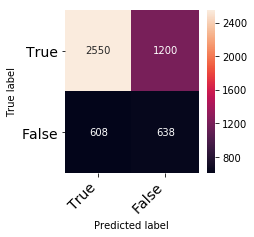

In [167]:
print_confusion_matrix(confusion_matrix(y_test, predicted) ,class_names=['True', 'False'], figsize = (3,3));

In [168]:
print(report)
print('AUC: ',random_search.best_score_)

              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74      3750
         1.0       0.35      0.51      0.41      1246

   micro avg       0.64      0.64      0.64      4996
   macro avg       0.58      0.60      0.58      4996
weighted avg       0.69      0.64      0.66      4996

AUC:  0.6621875487760961


In [169]:
predicted2 = random_search.predict(X_train)
report2 = classification_report(y_train, predicted2)
print(report2)

              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78     11249
         1.0       0.44      0.69      0.54      3737

   micro avg       0.70      0.70      0.70     14986
   macro avg       0.66      0.70      0.66     14986
weighted avg       0.76      0.70      0.72     14986



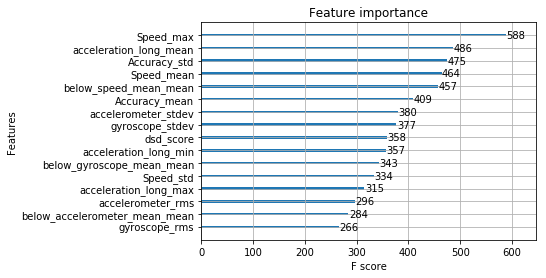

In [170]:
from xgboost import plot_importance
plot_importance(random_search.best_estimator_)